# Baseline model using non-network features of Crunchbase

**At a snapshot in time, can these features predict inclusion/exclusion in the Pledge 1% community?**

`p1_tag` ~  `rank` (numerical) + `employee_count` (ordinal) + `continent_code` (8 indicator columns) + `category_groups_list` (46 indicator columns)

This is the baseline model. In parentheses, you can note how these features are transformed in this notebook.

### Process Overview
1. Load in data and adjust columns
2. Convert `employee_count` to ordinal scale
3. Convert `continent_code` and `category_groups_list` to indicators columns
4. Filter out rows with missing data
5. Sample non-P1 organizations for the training and test data
6. Model using `LinearRegression`, `LogisticRegression`, `BernoulliNB`, and `KNeighborsClassifier`

**1 CSV file is created from this notebook**:

`df_model` $\rightarrow$ `files/output/baseline.csv`
- Organizations with their `uuid` and model features (listed above plus another `total_fundind_usd`), the encoded `country_code` and `category_groups_list` columns, and 46 indicator columns from the previous notebook.

In [1]:
# Add 'graph' environment to PATH
import sys
sys.path.append('/home/ski/anaconda3/envs/graph/lib/python3.8/site-packages')

# User defined functions
import base_methods
from importlib import reload
from base_methods import load_the_csvs, reformat_large_tick_values, column_formatter

# Import data analysis packages
import numpy as np
import pandas as pd
from datetime import datetime
import csv
import warnings
import os
import time
import itertools
import statistics
warnings.filterwarnings('ignore')

# Import plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3)
sns.set_style("white")

# Stats
from scipy.stats import chi2_contingency

# ML
import category_encoders as ce
from sklearn import metrics
from sklearn.linear_model  import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

## Loading data

In [2]:
# Store path to notebook
PWD = !pwd
PWD = PWD[0]

# Set global paths to data folders
!mkdir {PWD}/files/output/
print()
INPUT = PWD + '/files/csv/'
OUTPUT = PWD + '/files/output/'

# Load
df,df_industry = load_the_csvs(loc=OUTPUT, 
                               data=['organizations_merged','organizations_by_category_group'],
                               verbose=True)

# Get list of industries
industryFile = open(OUTPUT+'industries.txt', 'r')
industries = [line.strip('\n') for line in industryFile.readlines()]

# Define baseline features_
baseline_fields = ['uuid', 'p1_tag', 'rank', 'employee_count', 'country_code', 'category_groups_list', 
                   'total_funding_usd', 'age', 'continent_code']

mkdir: cannot create directory ‘/home/ski/Desktop/crunchbase-p1-machine-learning/files/output/’: File exists

/HOME/SKI/DESKTOP/CRUNCHBASE-P1-MACHINE-LEARNING/FILES/OUTPUT/ORGANIZATIONS_MERGED.CSV
ORGANIZATIONS_MERGED shape: (1131315, 18)
ORGANIZATIONS_MERGED columns: ['uuid', 'name', 'type', 'rank', 'roles', 'country_code', 'region', 'status', 'category_groups_list', 'total_funding_usd', 'founded_on', 'closed_on', 'employee_count', 'primary_role', 'p1_tag', 'p1_date', 'age', 'continent_code']

/HOME/SKI/DESKTOP/CRUNCHBASE-P1-MACHINE-LEARNING/FILES/OUTPUT/ORGANIZATIONS_BY_CATEGORY_GROUP.CSV
ORGANIZATIONS_BY_CATEGORY_GROUP shape: (1032614, 48)
ORGANIZATIONS_BY_CATEGORY_GROUP columns: ['uuid', 'Software', 'Information Technology', 'Internet Services', 'Data and Analytics', 'Sales and Marketing', 'Media and Entertainment', 'Commerce and Shopping', 'Financial Services', 'Apps', 'Mobile', 'Science and Engineering', 'Hardware', 'Health Care', 'Education', 'Artificial Intelligence', 'Professi

In [3]:
# Merge w/ industry dataframe
df = pd.merge(df, df_industry, how='left', on='uuid')

# Update column formats
df = column_formatter(df)
print('Starting Dataframe Columns:\n\n{}\n'.format(df.columns.to_list()))

# Select only columns in model
df_model = df[baseline_fields + industries]

# Create shorthand for industry columns
industry_map = {industry:'ind_'+str(idx+1) for idx,industry in enumerate(industries)}
industry_shorthand = list(industry_map.values())
df_model.rename(industry_map, axis=1, inplace=True)

print('Ending Dataframe Columns:\n\n{}\n'.format(df_model.columns.to_list()))

# Output
print('\nDataframe shape:', df_model.shape)

Starting Dataframe Columns:

['uuid', 'name', 'type', 'rank', 'roles', 'country_code', 'region', 'status', 'category_groups_list', 'total_funding_usd', 'founded_on', 'closed_on', 'employee_count', 'primary_role', 'p1_tag', 'p1_date', 'age', 'continent_code', 'Software', 'Information Technology', 'Internet Services', 'Data and Analytics', 'Sales and Marketing', 'Media and Entertainment', 'Commerce and Shopping', 'Financial Services', 'Apps', 'Mobile', 'Science and Engineering', 'Hardware', 'Health Care', 'Education', 'Artificial Intelligence', 'Professional Services', 'Design', 'Community and Lifestyle', 'Real Estate', 'Advertising', 'Transportation', 'Consumer Electronics', 'Lending and Investments', 'Sports', 'Travel and Tourism', 'Food and Beverage', 'Content and Publishing', 'Consumer Goods', 'Privacy and Security', 'Video', 'Payments', 'Sustainability', 'Events', 'Manufacturing', 'Clothing and Apparel', 'Administrative Services', 'Music and Audio', 'Messaging and Telecommunications

## Feature engineering

#### Use ordinal encoding on `employee_count` feature

The column values are ordinal (increasing value implies increasing size), so the integer assigned to each value is meaningful.

Reference: <a href='https://www.bogotobogo.com/python/scikit-learn/scikit_machine_learning_Data_Preprocessing-Missing-Data-Categorical-Data.php'>scikit-learn : Data Preprocessing I - Missing / categorical data</a>

In [4]:
mapper = [{'col':'employee_count', 'mapping':{'1-10':1,
                                              '11-50':2,
                                              '51-100':3,
                                              '101-250':4,
                                              '251-500':5,
                                              '501-1000':6,
                                              '1001-5000':7,
                                              '5001-10000':8,
                                              '10000+':9}}]
encoder_ordinal = ce.OrdinalEncoder(cols=['employee_count'], return_df=True, mapping=mapper)
df_model = encoder_ordinal.fit_transform(df_model)
df_model['employee_count'].replace(-1, np.NaN, inplace=True)
df_model[['p1_tag','rank','employee_count','country_code','continent_code','total_funding_usd','age']].head()

,p1_tag,rank,employee_count,country_code,continent_code,total_funding_usd,age
0,0,102736.0,3.0,USA,NorAm,3.975000e+07,15.0
1,0,24985.0,7.0,USA,NorAm,NaN,24.0
2,0,9319.0,3.0,USA,NorAm,4.900000e+07,16.0
3,0,29637.0,4.0,USA,NorAm,NaN,17.0
4,0,222.0,9.0,USA,NorAm,2.335700e+09,17.0


### Resources: dealing with high cardinality of features

<a href='https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/'>Here’s All you Need to Know About Encoding Categorical Data (with Python code)</a>
> Summary of Binary versus Hashing encoding

<a href='https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159'>Towards Data Science: Smarter Ways to Encode Categorical Data for Machine Learning</a>

> Better encoding of categorical data can mean better model performance. In this article I’ll introduce you to a wide range of encoding options from the Category Encoders package for use with scikit-learn machine learning in Python.

<a href='https://support.crunchbase.com/hc/en-us/articles/360043146954-What-Industries-are-included-in-Crunchbase-'>What Industries are included in Crunchbase? </a>

> Summary of Crunchbase's 46 Industry Groups

<a href='https://booking.ai/dont-be-tricked-by-the-hashing-trick-192a6aae3087'>Don’t be tricked by the Hashing Trick</a>

> The Hashing Trick is not parameter-free; the hashing space size must be decided beforehand. In this article, the Hashing Trick is described in depth, the effects of different hashing space sizes are illustrated with real world data sets, and a criterion to decide the hashing space size is constructed. If you can choose the hashing space on a per feature basis, use k² for features with less than a thousand categories and 20k for the others.
- If there is only one hashing space and less than twenty thousand features in total, use k², otherwise use n=20k.
- If you want to control for collisions as a proportion r of the features, then use n=k/r.

<a href='https://github.com/MaxHalford/prince#multiple-correspondence-analysis-mca'>MCA</a>

> Multiple correspondence analysis (MCA) is an extension of correspondence analysis (CA). It should be used when you have more than two categorical variables. The idea is simply to compute the one-hot encoded version of a dataset and apply CA on it.

<a href='https://towardsdatascience.com/one-hot-encoding-multicollinearity-and-the-dummy-variable-trap-b5840be3c41a'>One-Hot-Encoding, Multicollinearity and the Dummy Variable Trap</a>

<a href='https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02'>Towards Data Science: All about Categorical Variable Encoding</a>

<img src='https://miro.medium.com/max/1000/0*NBVi7M3sGyiUSyd5.png'>

#### Play around with using hashing encoding on nominal `country_code` feature.

Since there are $210$ unique country codes, what does the feature space look like when we set `n_components` $\approx 15$?

In [34]:
# # Create object for hash encoder
# n_components = 15
# encoder_hash = ce.HashingEncoder(cols='country_code',n_components=n_components)
# df_model = encoder_hash.fit_transform(df_model)
# df_model = df_model.rename(columns={'col_'+str(idx):'country_enc_'+str(idx+1) for idx in range(n_components)})
# df_model[df_model.columns[:n_components]].head(3)

,country_enc_1,country_enc_2,country_enc_3,country_enc_4,country_enc_5,country_enc_6,country_enc_7,country_enc_8,country_enc_9,country_enc_10,...,ind_37,ind_38,ind_39,ind_40,ind_41,ind_42,ind_43,ind_44,ind_45,ind_46
0,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Try using hashing encoding on nominal industry features from `category_groups_list`? 

`category_groups_list` was already converted to indicator columns in a previous notebook (using one-hot encoding). The one-hot encoder creates a column for each value to compare against all other values. For each column, a row gets a 1 if the row contained that column’s value and a 0 if it did not. This results in 46 columns that can have a value of 1 for multiple columns. Industries can have similar values, so it is likely that there is some correlation between industry types.

We can compare with an alternate model that reduces the 38,379 unique values of `category_groups_list` into a minimal set of columns.

In [38]:
# # Create object for hash encoder
# n_components = 46
# encoder_hash = ce.HashingEncoder(cols='category_groups_list',n_components=n_components)
# df_model = encoder_hash.fit_transform(df_model)
# df_model = df_model.rename(columns={'col_'+str(idx):'ind_enc_'+str(idx+1) for idx in range(n_components)})
# df_model[df_model.columns[:n_components]].head(3)

,ind_enc_1,ind_enc_2,ind_enc_3,ind_enc_4,ind_enc_5,ind_enc_6,ind_enc_7,ind_enc_8,ind_enc_9,ind_enc_10,...,ind_enc_37,ind_enc_38,ind_enc_39,ind_enc_40,ind_enc_41,ind_enc_42,ind_enc_43,ind_enc_44,ind_enc_45,ind_enc_46
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Use one hot encoding on nominal `continent_code` feature.

Since there are $8$ unique continent codes, we will get $8$ dummy indicator columns

In [5]:
saved = df_model['continent_code']
df_model = pd.get_dummies(df_model, columns=['continent_code'], prefix='cont').rename({'cont_NorAm':'cont_NA'}, axis=1)
df_model['continent_code'] = saved
df_model[['p1_tag','rank','employee_count','country_code','continent_code','total_funding_usd','age',
          'cont_AF', 'cont_AS', 'cont_EU', 'cont_NA', 'cont_OC', 'cont_SA']].head()

,p1_tag,rank,employee_count,country_code,continent_code,total_funding_usd,age,cont_AF,cont_AS,cont_EU,cont_NA,cont_OC,cont_SA
0,0,102736.0,3.0,USA,NorAm,3.975000e+07,15.0,0,0,0,1,0,0
1,0,24985.0,7.0,USA,NorAm,NaN,24.0,0,0,0,1,0,0
2,0,9319.0,3.0,USA,NorAm,4.900000e+07,16.0,0,0,0,1,0,0
3,0,29637.0,4.0,USA,NorAm,NaN,17.0,0,0,0,1,0,0
4,0,222.0,9.0,USA,NorAm,2.335700e+09,17.0,0,0,0,1,0,0


In [75]:
# Save to CSV
print('Model shape:', df_model.shape)
df_model.to_csv(OUTPUT+'baseline.csv', index=False, sep=';')
print(f'OUTPUT TO CSV {OUTPUT}')

Model shape: (1131325, 61)
OUTPUT TO CSV /home/ski/Desktop/crunchbase-p1-machine-learning/files/output/


## Dealing with missing data: remove (for now)

Remove rows with missing `rank`, `employee_count`, `country_code`, and `category_groups_list` values

In [6]:
features = ['rank','employee_count','continent_code','category_groups_list']
df_num_missing = df_model[features].isna().sum()/len(df_model)
output_string = df_num_missing.to_string(float_format=lambda x: '{:.2f}%'.format(x*100))
print('BEFORE...\n')
print('MISSING VALUES BY PERCENTAGE\n')
print(output_string)

df_model=df_model[df_model['category_groups_list'].notna() & 
                  df_model['employee_count'].notna() & 
                  df_model['continent_code'].notna() & 
                  df_model['rank'].notna()]

df_num_missing = df_model[features].isna().sum()/len(df_model)
output_string = df_num_missing.to_string(float_format=lambda x: '{:.2f}%'.format(x*100))
print('\nAFTER...\n')
print('MISSING VALUES BY PERCENTAGE\n')
print(output_string)
del output_string, df_num_missing

BEFORE...

MISSING VALUES BY PERCENTAGE

rank                    4.13%
employee_count         27.58%
continent_code         17.30%
category_groups_list    8.72%

AFTER...

MISSING VALUES BY PERCENTAGE

rank                   0.00%
employee_count         0.00%
continent_code         0.00%
category_groups_list   0.00%


# Baseline model

#### Select equal sample of non-Pledge 1% organizations

Reference: <a href='https://cmdlinetips.com/2018/02/how-to-randomly-select-rows-in-pandas-pandas-tutorial/'>How To Randomly Select Rows in Pandas?</a>

In [7]:
df_model_p1 = df_model[df_model['p1_tag']==1]
df_model_cb = df_model[df_model['p1_tag']==0].sample(n=df_model_p1.shape[0], replace=False)
df_model_baseline = pd.concat([df_model_p1, df_model_cb]).reset_index(drop=True)
print('Baseline model shape:', df_model_baseline.shape)

Baseline model shape: (12126, 61)


### Correlation matrix with industry variables

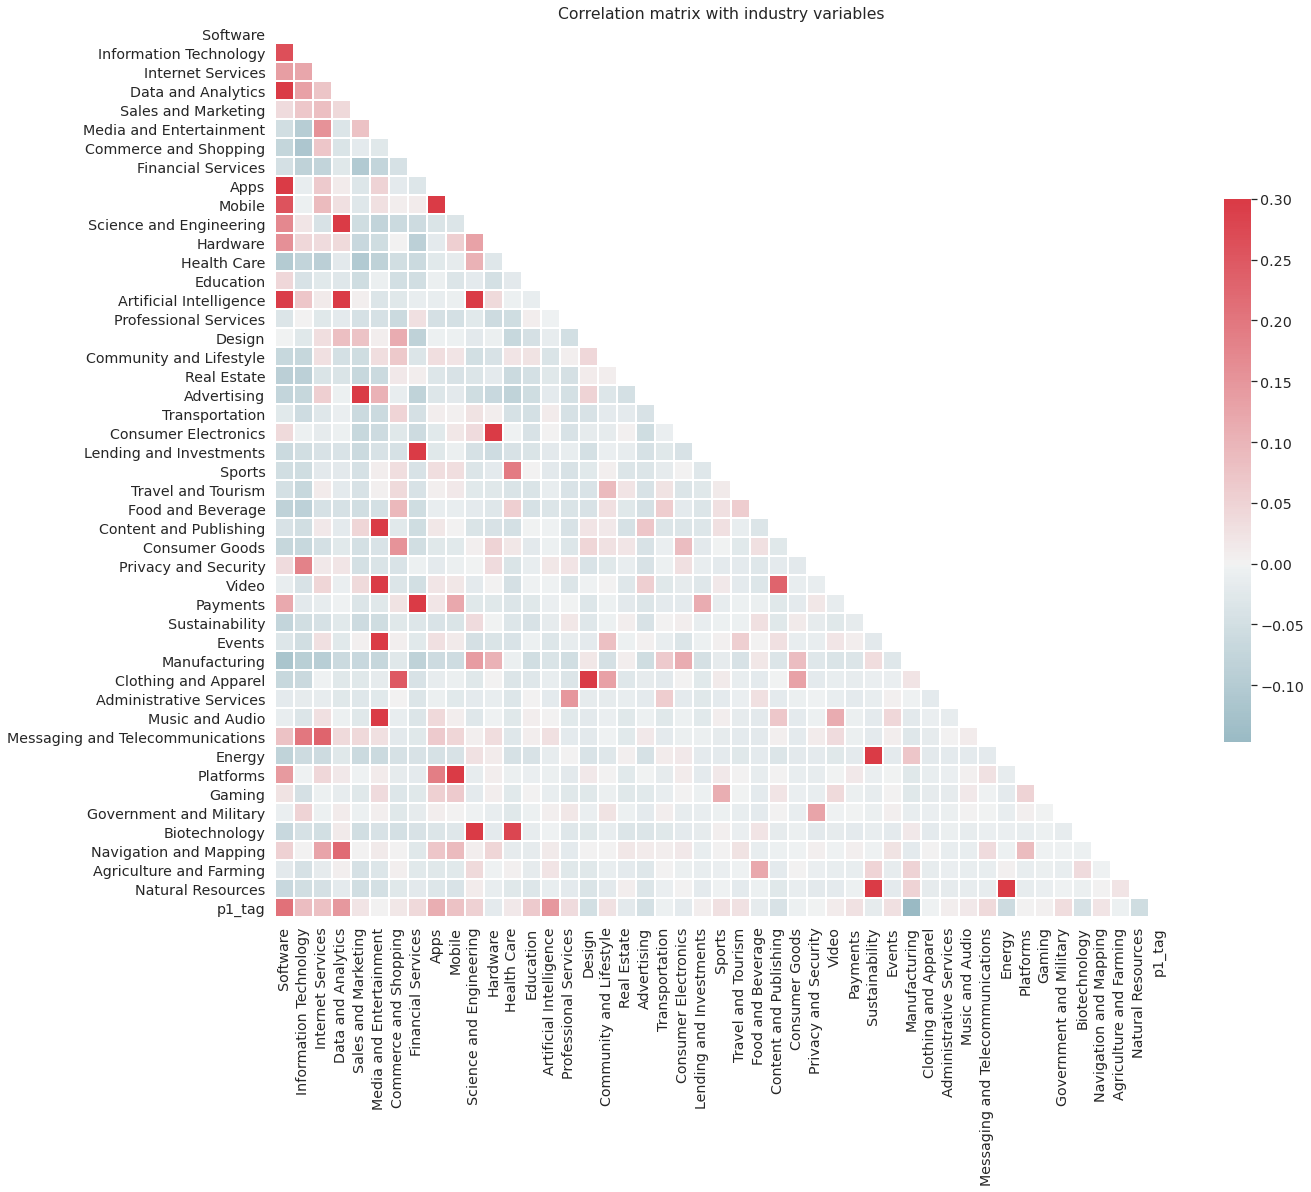

In [8]:
# Compute the correlation matrix
cols = ['ind_1', 'ind_2', 'ind_3', 'ind_4', 'ind_5', 'ind_6', 'ind_7', 'ind_8',
       'ind_9', 'ind_10', 'ind_11', 'ind_12', 'ind_13', 'ind_14', 'ind_15',
       'ind_16', 'ind_17', 'ind_18', 'ind_19', 'ind_20', 'ind_21', 'ind_22',
       'ind_23', 'ind_24', 'ind_25', 'ind_26', 'ind_27', 'ind_28', 'ind_29',
       'ind_30', 'ind_31', 'ind_32', 'ind_33', 'ind_34', 'ind_35', 'ind_36',
       'ind_37', 'ind_38', 'ind_39', 'ind_40', 'ind_41', 'ind_42', 'ind_43',
       'ind_44', 'ind_45', 'ind_46', 'p1_tag']
industry_map_reverse = {value:key for key, value in industry_map.items()}
corr_df = df_model_baseline[cols].rename(industry_map_reverse, axis=1)
corr = corr_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)
plt.title('Correlation matrix with industry variables')
plt.show()

The industries were sorted numerically in ascending order by the popularity of the industry within the Pledge 1% dataset. You can see that the most popular industry, Software, has the strongest positive correlation with the outcome variable.

### Correlation matrix with continent variables

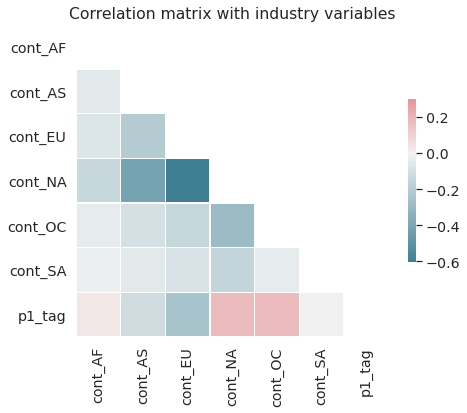

In [9]:
# Compute the correlation matrix
cols = ['cont_AF', 'cont_AS', 'cont_EU', 'cont_NA', 'cont_OC', 'cont_SA', 'p1_tag']
corr = df_model_baseline[cols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)
plt.title('Correlation matrix with industry variables')
plt.show()

### Correlation matrix with numeric variables

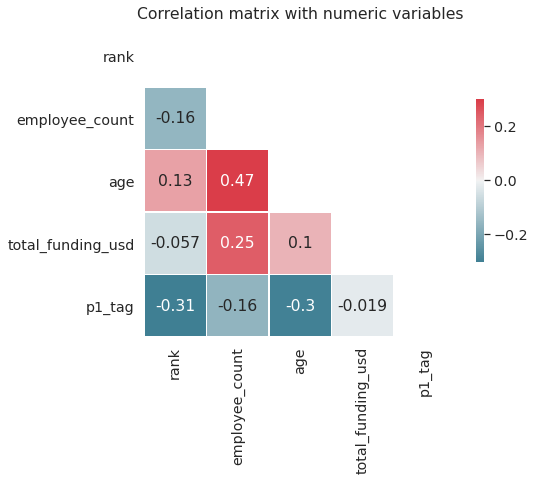

In [10]:
# Compute the correlation matrix
cols = ['rank','employee_count','age','total_funding_usd','p1_tag']
corr = df_model_baseline[cols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title('Correlation matrix with numeric variables')
plt.show()

### Cramer's V correlation matrix for categorical variables

From: <a href='https://stackoverflow.com/questions/51859894/how-to-plot-a-cramer-s-v-heatmap-for-categorical-features'>Stack overflow</a>

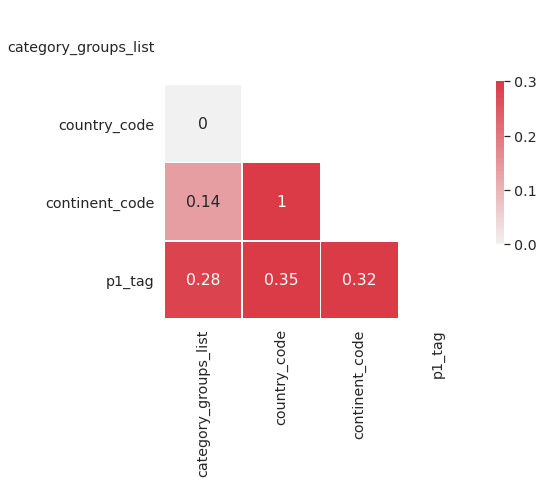

In [11]:
'''Correlation with categorical variables'''
def cramers_corrected_stat(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

# Compute the correlation matrix
cols = ['category_groups_list','country_code','continent_code','p1_tag']
corrM = np.zeros((len(cols),len(cols)))

for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df_model_baseline[col1], df_model_baseline[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]
    
# Compute the correlation matrix
corr2 = pd.DataFrame(corrM, index=cols, columns=cols)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

### Split data into training and test, use MinMax scaling

In [12]:
# Drop unusable columns
df_model_baseline = df_model_baseline.drop(['uuid','country_code','continent_code','category_groups_list','total_funding_usd', 'age'], axis=1)

In [13]:
# Split dataframe into X and y
X = df_model_baseline.loc[:,~df_model_baseline.columns.isin(['p1_tag'])]
y = df_model_baseline.loc[:,df_model_baseline.columns.isin(['p1_tag'])]

# spliting the clean dataset into 70/30 for training/ test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print('training data shape:', X_train.shape)
print('train label shape:', y_train.shape)
print('test data shape:',  X_test.shape)
print('test label shape:', y_test.shape)

training data shape: (8488, 54)
train label shape: (8488, 1)
test data shape: (3638, 54)
test label shape: (3638, 1)


In [14]:
# fit scaler on training data
norm = MinMaxScaler().fit(X_train)
# transform training data
X_train = norm.transform(X_train)
# transform testing dataabs
X_test = norm.transform(X_test)

### Linear regression with `LinearRegression`

In [16]:
# Training model using linear regression
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

# Predicting y 
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score:', r2_score(y_test, y_pred))
print('Score:', regressor.score(X_test, y_test))

Mean Absolute Error: 0.38027074980565384
Mean Squared Error: 0.1882145363743273
Root Mean Squared Error: 0.43383699286059885
R2 Score: 0.24684685390357175
Score: 0.24684685390357175


### K-Nearest Neighbor with `KNeighborsClassifier`

In [17]:
k_values = {'n_neighbors': np.arange(1,29,2)}
KNN_cross_val = GridSearchCV(KNeighborsClassifier(), param_grid=k_values, scoring='accuracy')
KNN_cross_val.fit(X_train, y_train)
best_neighbor = KNN_cross_val.best_params_['n_neighbors']
KNN = KNeighborsClassifier(n_neighbors=best_neighbor)
KNN.fit(X_train, y_train)

y_pred = KNN.predict(X_test)
num_wrong = sum(y_test.values.reshape(len(y_test)) != y_pred)
print('CV selection of k={}: Number misclassified ... {} out of {}'.format(best_neighbor, num_wrong, len(y_test)))
print('Accuracy score:', KNN.score(X_test, y_test))
print('F1 score:', f1_score(y_test, y_pred))

CV selection of k=19: Number misclassified ... 1073 out of 3638
Accuracy score: 0.7050577240241891
F1 score: 0.7018616282300639


### Naive Bayes with `BernoulliNB`

In [18]:
alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 100.0]}
NB_cross_val = GridSearchCV(BernoulliNB(), param_grid=alphas, scoring='accuracy')
NB_cross_val.fit(X_train, y_train)
best_alpha = NB_cross_val.best_params_['alpha']
NB = MultinomialNB(alpha=best_alpha)
NB.fit(X_train, y_train)

y_pred = NB.predict(X_test)
num_wrong = sum(y_test.values.reshape(len(y_test)) != y_pred)
print('CV selection of alpha={}: Number misclassified ... {} out of {}'.format(best_alpha, num_wrong, len(y_test)))
print('Accuracy score:', NB.score(X_test, y_test))
print('F1 score:', f1_score(y_test, y_pred))

CV selection of alpha=100.0: Number misclassified ... 1120 out of 3638
Accuracy score: 0.6921385376580539
F1 score: 0.6992481203007519


### Logistic Regression with `LogisticRegression`

In [19]:
Cs = {'C': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 5.0, 10.0, 100.0]}
LR_cross_val = GridSearchCV(LogisticRegression(), param_grid=Cs, scoring='accuracy')
LR_cross_val.fit(X_train, y_train)
best_C = LR_cross_val.best_params_['C']
LR = LogisticRegression(C=best_C)
LR.fit(X_train, y_train)

y_pred = LR.predict(X_test)
num_wrong = sum(y_test.values.reshape(len(y_test)) != y_pred)
print('CV selection of alpha={}: Number misclassified ... {} out of {}'.format(best_C, num_wrong, len(y_test)))
print('Accuracy score:', LR.score(X_test, y_test))
print('F1 score:', f1_score(y_test, y_pred))

CV selection of alpha=0.5: Number misclassified ... 1024 out of 3638
Accuracy score: 0.7185266630016492
F1 score: 0.7223427331887202



### Bootstrapping model running for 10 iterations to calculate the average of accuracy scores

In [23]:
n_iter = 10

# Define lists to capture different accuracies
Linear_scores = []
NB_scores = []
KNN_scores = []
LR_scores = []
NB_scores_f1 = []
KNN_scores_f1 = []
LR_scores_f1 = []

print(f'\n*************** Beginning of {n_iter} iterations ***************')    
for i in range(n_iter):
    
    print(f'ITERATION {str(i+1)} OUT OF {n_iter}')
    
    df_model_p1 = df_model[df_model['p1_tag']==1]
    df_model_cb = df_model[df_model['p1_tag']==0].sample(n=df_model_p1.shape[0], replace=False)
    df_model_baseline = pd.concat([df_model_p1, df_model_cb]).reset_index(drop=True)
    df_model_baseline = df_model_baseline.drop(['uuid','country_code','continent_code',
                                                'category_groups_list','total_funding_usd','age'], axis=1)
    X = df_model_baseline.loc[:,~df_model_baseline.columns.isin(['p1_tag'])]
    y = df_model_baseline.loc[:,df_model_baseline.columns.isin(['p1_tag'])]

    # spliting the clean dataset into 70/30 for training and test
    # Removed random_state=1 to avoid seeding so that we can get random results in each iteration
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    # fit scaler on training data
    norm = MinMaxScaler().fit(X_train)
    # transform training data
    X_train = norm.transform(X_train)
    # transform testing dataabs
    X_test = norm.transform(X_test)
    
    # Linear regression
    regressor = LinearRegression()  
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    Linear_scores.append(r2_score(y_test, y_pred))
    
    # Naive Bayes
    NB = BernoulliNB(alpha=best_alpha)
    NB.fit(X_train, y_train)
    NB_scores_f1.append(f1_score(y_test,NB.predict(X_test)))
    NB_scores.append(NB.score(X_test, y_test))
    
    # K-Nearest Neighbor
    KNN = KNeighborsClassifier(n_neighbors=best_neighbor)
    KNN.fit(X_train, y_train)
    KNN_scores_f1.append(f1_score(y_test,KNN.predict(X_test)))
    KNN_scores.append(KNN.score(X_test, y_test))
    
    # Logistic Regression
    LR = LogisticRegression(C=best_C)
    LR.fit(X_train, y_train)
    LR_scores_f1.append(f1_score(y_test,LR.predict(X_test)))
    LR_scores.append(LR.score(X_test, y_test))
    
print(f'*************** End of {n_iter} iterations ***************\n')    
print('Averaged Linear Regression accuracy score:', round(statistics.mean(Linear_scores),4))
print('Averaged Logistic Regression accuracy Score:', round(statistics.mean(LR_scores),4))
print('Averaged Logistic Regression f1 Score:', round(statistics.mean(LR_scores_f1),4))
print('Averaged Naive Bayes accuracy score:', round(statistics.mean(NB_scores),4))
print('Averaged Naive Bayes f1 score:', round(statistics.mean(NB_scores_f1),4))
print('Averaged K-Nearest Neighbour accuracy score:', round(statistics.mean(KNN_scores),4))
print('Averaged K-Nearest Neighbour f1 score:', round(statistics.mean(KNN_scores_f1),4))


*************** Beginning of 10 iterations ***************
ITERATION 1 OUT OF 10
ITERATION 2 OUT OF 10
ITERATION 3 OUT OF 10
ITERATION 4 OUT OF 10
ITERATION 5 OUT OF 10
ITERATION 6 OUT OF 10
ITERATION 7 OUT OF 10
ITERATION 8 OUT OF 10
ITERATION 9 OUT OF 10
ITERATION 10 OUT OF 10
*************** End of 10 iterations ***************

Averaged Linear Regression accuracy score: 0.247
Averaged Logistic Regression accuracy Score: 0.7206
Averaged Logistic Regression f1 Score: 0.7263
Averaged Naive Bayes accuracy score: 0.6859
Averaged Naive Bayes f1 score: 0.6854
Averaged K-Nearest Neighbour accuracy score: 0.6991
Averaged K-Nearest Neighbour f1 score: 0.6997
